In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers 
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext 
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
from  sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from joblib import Parallel, delayed

In [33]:
#檢查 GPU
import tensorflow as tf
# print('gpu',tf.test.is_gpu_available())
# import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [35]:
import os
DIR = 'train_final' #要統計的資料夾
print (len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

65632


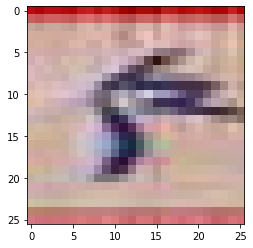

In [36]:
import matplotlib.pyplot as plt
train_image = Image.open('train_final/0_戶.jpg')
train_image = train_image.resize((26,26))
plt.imshow(train_image)
plt.show()

### 圖片處理

In [37]:
jpglist = glob('./train_final/*.[jJ][pP][gG]')
jpglist

['./train_final/53416_敦.jpg',
 './train_final/34686_禮.jpg',
 './train_final/52090_穎.jpg',
 './train_final/36582_邦.jpg',
 './train_final/43382_晉.jpg',
 './train_final/33120_邱.jpg',
 './train_final/13512_行.jpg',
 './train_final/17651_亞.jpg',
 './train_final/2514_廈.jpg',
 './train_final/59647_爾.jpg',
 './train_final/34593_孫.jpg',
 './train_final/18715_芳.jpg',
 './train_final/57755_佳.jpg',
 './train_final/10681_泓.jpg',
 './train_final/27551_網.jpg',
 './train_final/13813_古.jpg',
 './train_final/23821_旭.jpg',
 './train_final/17009_承.jpg',
 './train_final/10270_鄭.jpg',
 './train_final/15475_齊.jpg',
 './train_final/7892_旻.jpg',
 './train_final/39066_券.jpg',
 './train_final/30967_不.jpg',
 './train_final/39106_雲.jpg',
 './train_final/27974_劉.jpg',
 './train_final/64262_公.jpg',
 './train_final/64681_備.jpg',
 './train_final/24139_蕙.jpg',
 './train_final/11084_勝.jpg',
 './train_final/62902_林.jpg',
 './train_final/66245_市.jpg',
 './train_final/19911_瑩.jpg',
 './train_final/33471_合.jpg',
 './train_fi

In [38]:
image_width = 26
image_height = 26

In [39]:
#銳利化 
chinese_word_1 = []   #y_label
chinese_image_1 = []  #X_train_圖片

print('建立kernel-1、銳利化')
kernel1 = np.array((
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]),
     dtype='int')
print(kernel1)

for i in jpglist:
    im = Image.open(i) 
    im2 = im.resize((image_width,image_height))
    filter1 = cv2.filter2D(np.array(im2),-1,kernel1) 
    chinese_image_1.append(filter1)
    label = i[-5 :-4]        #擷取label
    chinese_word_1 += label
    
filter1_image = np.array(chinese_image_1)
x_train_filter = filter1_image.astype(np.float32)
x_train_filter.shape

建立kernel-1、銳利化
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


(65632, 26, 26, 3)

y_label

In [40]:
#查看train分類
chinese_word_2 = []   
for x in chinese_word_1:
    if x not in chinese_word_2:
        chinese_word_2.append(x)
print(len(chinese_word_1),len(chinese_word_2))
#chinese_word_2 有幾個字 unique

65632 844


In [41]:
# y_label
inside_labels = {v: k for (k, v) in zip(np.arange(len(chinese_word_2)), chinese_word_2)} #字典
label = [inside_labels[chinese_word_1[i]]for i in range(len(chinese_word_1))] #將train做label
image_label=np.array(label) #轉陣列
image_label.shape

(65632,)

In [42]:

x_train_name = x_train_filter
mean = np.mean(x_train_name,axis=(0,1,2,3))
std = np.std(x_train_name,axis=(0,1,2,3))
x_train_name = (x_train_name-mean)/(std+1e-7)

#one hot encoding
y_train_1 = to_categorical(image_label)
(y_train_1[0], image_label[0])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [43]:
num_classes = len(chinese_word_2)
num_classes

844

In [44]:
x_train_name.shape[1:]

(26, 26, 3)

In [45]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [46]:
num_classes = len(chinese_word_2)

#add(filter, kernal)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay),
                 input_shape=(x_train_name.shape[1:])))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(96,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(96,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)       

In [47]:
#資訊增益
datagen = ImageDataGenerator(
                width_shift_range = 0.05,   
                height_shift_range = 0.05,
                shear_range = 0.5,
                channel_shift_range = 20
                )

#zca_whitening=false
#shear_range
#zoom_range
#rotation_range
#channel_shift_range
#fill_mode='reflect'
#             'wrap'
#             'nearest'
#             'constant'

In [48]:
x_train, x_test,y_train, y_test= train_test_split(x_train_filter, y_train_1, test_size=0.1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((59068, 26, 26, 3), (59068, 844), (6564, 26, 26, 3), (6564, 844))

In [49]:
model.compile( optimizer = 'Adam',loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [54]:
Batch_size = 16
Epochs = 200
history = model.fit(datagen.flow(x_train,y_train),
                  batch_size = Batch_size,
                  epochs = Epochs,
                  validation_data=(x_test, y_test),
                  verbose=1,
                  callbacks=[LearningRateScheduler(lr_schedule)]
)

Epoch 1/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.7510 - accuracy: 0.8968 - val_loss: 1.4858 - val_accuracy: 0.8023
Epoch 2/200
1846/1846 [==============================] - 34s 18ms/step - loss: 0.7496 - accuracy: 0.8974 - val_loss: 1.5247 - val_accuracy: 0.7972
Epoch 3/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.7279 - accuracy: 0.9009 - val_loss: 1.5850 - val_accuracy: 0.8012
Epoch 4/200
1846/1846 [==============================] - 32s 18ms/step - loss: 0.7279 - accuracy: 0.9020 - val_loss: 1.5334 - val_accuracy: 0.8087
Epoch 5/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.7209 - accuracy: 0.9043 - val_loss: 1.5352 - val_accuracy: 0.8018
Epoch 6/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.7159 - accuracy: 0.9041 - val_loss: 1.5393 - val_accuracy: 0.8029
Epoch 7/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.6990 - accuracy: 0.9070 - val_loss: 1

1846/1846 [==============================] - 33s 18ms/step - loss: 0.5722 - accuracy: 0.9305 - val_loss: 1.5290 - val_accuracy: 0.8094
Epoch 57/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.5702 - accuracy: 0.9308 - val_loss: 1.5057 - val_accuracy: 0.8144
Epoch 58/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.5641 - accuracy: 0.9322 - val_loss: 1.5378 - val_accuracy: 0.8090
Epoch 59/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.5710 - accuracy: 0.9304 - val_loss: 1.5374 - val_accuracy: 0.8047
Epoch 60/200
1846/1846 [==============================] - 34s 18ms/step - loss: 0.5670 - accuracy: 0.9308 - val_loss: 1.5605 - val_accuracy: 0.8058
Epoch 61/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.5608 - accuracy: 0.9332 - val_loss: 1.4958 - val_accuracy: 0.8105
Epoch 62/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.5646 - accuracy: 0.9305 - val_loss: 1.4617 

1846/1846 [==============================] - 32s 18ms/step - loss: 0.2313 - accuracy: 0.9778 - val_loss: 1.3843 - val_accuracy: 0.8408
Epoch 112/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2262 - accuracy: 0.9774 - val_loss: 1.4170 - val_accuracy: 0.8413
Epoch 113/200
1846/1846 [==============================] - 34s 18ms/step - loss: 0.2305 - accuracy: 0.9757 - val_loss: 1.4358 - val_accuracy: 0.8378
Epoch 114/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2231 - accuracy: 0.9783 - val_loss: 1.3979 - val_accuracy: 0.8391
Epoch 115/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2270 - accuracy: 0.9768 - val_loss: 1.3696 - val_accuracy: 0.8406
Epoch 116/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2214 - accuracy: 0.9774 - val_loss: 1.3967 - val_accuracy: 0.8417
Epoch 117/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2227 - accuracy: 0.9760 - val_loss: 1

1846/1846 [==============================] - 33s 18ms/step - loss: 0.1998 - accuracy: 0.9763 - val_loss: 1.3717 - val_accuracy: 0.8448
Epoch 167/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.1985 - accuracy: 0.9765 - val_loss: 1.3619 - val_accuracy: 0.8419
Epoch 168/200
1846/1846 [==============================] - 34s 18ms/step - loss: 0.1974 - accuracy: 0.9775 - val_loss: 1.3883 - val_accuracy: 0.8370
Epoch 169/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2013 - accuracy: 0.9765 - val_loss: 1.4164 - val_accuracy: 0.8390
Epoch 170/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.2022 - accuracy: 0.9761 - val_loss: 1.3657 - val_accuracy: 0.8397
Epoch 171/200
1846/1846 [==============================] - 34s 19ms/step - loss: 0.1972 - accuracy: 0.9777 - val_loss: 1.4155 - val_accuracy: 0.8339
Epoch 172/200
1846/1846 [==============================] - 33s 18ms/step - loss: 0.1970 - accuracy: 0.9774 - val_loss: 1

In [55]:
scores = model.evaluate(x_test, y_test, batch_size=Batch_size, verbose=1)
scores

411/411 [==============================] - 1s 2ms/step - loss: 1.4249 - accuracy: 0.8358


[1.42494797706604, 0.835770845413208]

Text(0, 0.5, 'accuracy')

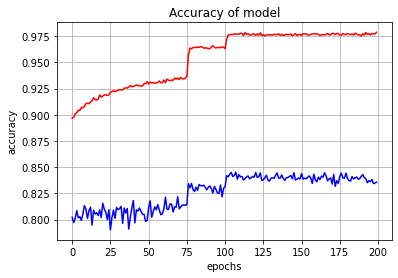

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Accuracy of model')
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='blue')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

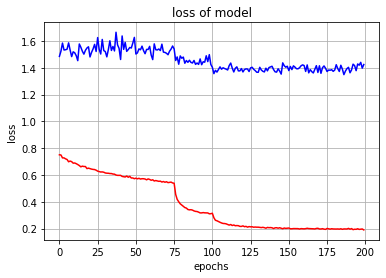

In [57]:
plt.title('loss of model')
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')

In [58]:
print(x_test.shape, y_test.shape)

(6564, 26, 26, 3) (6564, 844)


In [59]:
#預測
y_pred = model.predict(x_test)
y_hat = np.argmax(y_pred, axis=1)
y_hat

array([645, 446, 143, ..., 733, 668, 723])

In [60]:
# 混淆矩陣/交叉表
import pandas as pd
pd.crosstab(y_test.argmax(axis=1),y_hat,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,797,798,799,800,801
label,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# 精準度 召回率  調和平均值 F-score
print(classification_report(y_test.argmax(axis=1), y_hat))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         9
           2       0.71      1.00      0.83        12
           3       1.00      1.00      1.00         4
           4       0.85      0.79      0.81        14
           5       1.00      0.88      0.93         8
           6       0.69      0.85      0.76        13
           7       1.00      1.00      1.00         7
           8       0.57      0.89      0.70         9
           9       0.73      1.00      0.84         8
          10       0.91      0.83      0.87        12
          11       0.92      0.92      0.92        13
          12       0.80      0.67      0.73        12
          13       1.00      0.80      0.89        10
          14       0.75      0.86      0.80         7
          15       0.75      0.67      0.71         9
          16       0.90      0.82      0.86        11
          17       1.00    

/home/409186059/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/409186059/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
